# workshop unit-2
## Building-an-AI-Classifier-Identifying-Cats-Dogs-Pandas-with-PyTorch
**Name:** PRIYADHARSHINI S
**REG NO:** 212223240129
**SLOT NO.** 4O1-1


Classes: ['cats', 'dogs', 'panda']
Using device: cpu
Epoch 1/5, Loss: 0.3127, Acc: 0.8779
Epoch 2/5, Loss: 0.1697, Acc: 0.9343
Epoch 3/5, Loss: 0.1816, Acc: 0.9239
Epoch 4/5, Loss: 0.1483, Acc: 0.9409
Epoch 5/5, Loss: 0.1535, Acc: 0.9367

Test Accuracy: 98.53%


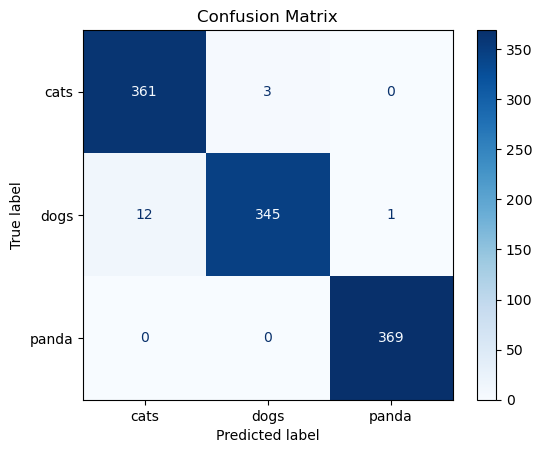

In [1]:
# ==========================================
# 1. IMPORTS & SETUP
# ==========================================
import zipfile
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 2. UNZIP DATASET
# ==========================================
zip_path = r"C:\Users\admin\Downloads\Building-an-AI-Classifier-Identifying-Cats-Dogs-Pandas-with-PyTorch-main.zip"
extract_path = r"C:\Users\admin\Downloads\cat_dog_data"

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Adjust path if ZIP has top-level folder
top_level_folders = os.listdir(extract_path)
if len(top_level_folders) == 1 and os.path.isdir(os.path.join(extract_path, top_level_folders[0])):
    extract_path = os.path.join(extract_path, top_level_folders[0], "dataset")

train_dir = os.path.join(extract_path, "train")
test_dir  = os.path.join(extract_path, "test")

if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise RuntimeError("Train/Test folders not found in the extracted dataset.")

# ==========================================
# 3. DATA PREPARATION
# ==========================================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)

class_names = train_data.classes
print("Classes:", class_names)

# ==========================================
# 4. MODEL DESIGN (Transfer Learning with ResNet18)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Use modern weights API instead of deprecated `pretrained`
weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

# Freeze backbone parameters
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for our classes
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# ==========================================
# 5. TRAINING
# ==========================================
epochs = 5  # Adjust as needed
for epoch in range(epochs):
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = correct / len(train_data)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

# ==========================================
# 6. EVALUATION
# ==========================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ==========================================
# 7. BONUS – PREDICTION FUNCTION
# ==========================================
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = test_transforms(img).unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        prob = torch.softmax(outputs, dim=1)[0][pred].item() * 100

    result = class_names[pred.item()]
    print(f"Prediction: {result} ({prob:.2f}% confidence)")
    return result
